# COMP30027 Machine Learning Assignment 2

Student Name(s): Haonan Zhong

Student ID(s): 867492

In [1]:
import numpy as np
import pandas as pd

train_data = pd.read_csv(r"recipe_train.csv", index_col = False, delimiter = ',', header=0)
test_data = pd.read_csv(r"recipe_test.csv", index_col = False, delimiter = ',', header=0)

In [2]:
d = {'label':train_data['duration_label'].value_counts().index, 'count':train_data['duration_label'].value_counts()}
pd.DataFrame(d)

,label,count
2.0,2.0,20246
1.0,1.0,17705
3.0,3.0,2049


## Feature Engineering

In [3]:
# converts all character to lower case and removes punctuations

train_data['steps'] = train_data['steps'].str.lower()
train_data['steps'] = train_data['steps'].str.replace("'s", "")
test_data['steps'] = test_data['steps'].str.lower()
test_data['steps'] = test_data['steps'].str.replace("'s", "")

punctuation_signs = list("()[]?:!.,;&'%")
for punct_sign in punctuation_signs:
    train_data['steps'] = train_data['steps'].str.replace(punct_sign, '')
    test_data['steps'] = test_data['steps'].str.replace(punct_sign, '')

In [4]:
import nltk

# lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

train_data['steps'] = train_data['steps'].apply(lemmatize_text).apply(' '.join)
test_data['steps'] = test_data['steps'].apply(lemmatize_text).apply(' '.join)

In [5]:
from sklearn.model_selection import train_test_split

# split the training data into train and holdout validation set
X_train, X_dev, y_train, y_dev = train_test_split(train_data['steps'], train_data['duration_label'], test_size=0.20, random_state=10)

X_test = test_data['steps']

print(X_train.shape, X_dev.shape, y_train.shape, y_dev.shape)

(32000,) (8000,) (32000,) (8000,)


## Count Vectorization

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# preprocess text and compute counts
cv = CountVectorizer(stop_words='english').fit(X_train)

x_train_count = cv.transform(X_train)
x_dev_count = cv.transform(X_dev)
x_test_count = cv.transform(X_test)

## Multinomial Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(x_train_count, y_train)
print("Training Accuracy:", mnb.score(x_train_count, y_train))
print("Holdout Accuracy:", mnb.score(x_dev_count, y_dev))
validation_set_prediction = mnb.predict(x_dev_count)

Training Accuracy: 0.75075
Holdout Accuracy: 0.73025


In [8]:
# 5-fold cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

folds = StratifiedKFold(n_splits=5)
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer(stop_words='english')),
    ('Multinomial NB', MultinomialNB())
])

scores = cross_val_score(pipeline, X_train, y_train, cv=folds)
print("Stratified 5-fold Cross Validation Averaged Accuracy:", scores.mean())
print(scores)

Stratified 5-fold Cross Validation Averaged Accuracy: 0.7258125
[0.7175     0.735      0.72671875 0.7228125  0.72703125]


              precision    recall  f1-score   support

         1.0       0.72      0.72      0.72      3508
         2.0       0.76      0.75      0.75      4058
         3.0       0.58      0.64      0.61       434

    accuracy                           0.73      8000
   macro avg       0.68      0.70      0.69      8000
weighted avg       0.73      0.73      0.73      8000



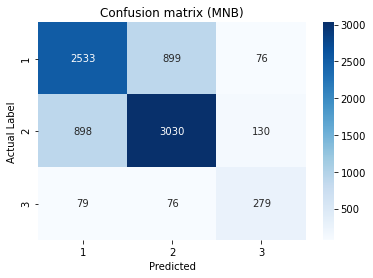

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_dev, validation_set_prediction))
conf_matrix = confusion_matrix(y_dev, validation_set_prediction)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.title('Confusion matrix (MNB)')
plt.xlabel('Predicted')
plt.ylabel('Actual Label')
plt.show()

In [9]:
# Multinomial Naive Bayes test set Prediction

mnb.predict(x_test_count)

array([2., 1., 2., ..., 1., 1., 2.])

## TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english' ,min_df=10, max_df=0.9, ngram_range=(1,2)).fit(X_train)
x_train_tfidf = tfidf.transform(X_train)
x_dev_tfidf = tfidf.transform(X_dev)
x_test_tfidf = tfidf.transform(X_test)

## Feature Selection

In [12]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

mi = SelectKBest(score_func=mutual_info_classif, k=1000)
x_train_mi = mi.fit_transform(x_train_tfidf, y_train)
x_dev_mi = mi.transform(x_dev_tfidf)
x_test_mi = mi.transform(x_test_tfidf)

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)

lr.fit(x_train_mi, y_train)
print("Training Accuracy:", lr.score(x_train_mi, y_train))
print("Holdout Accuracy:", lr.score(x_dev_mi, y_dev))
validation_set_prediction = lr.predict(x_dev_mi)

Training Accuracy: 0.8065
Holdout Accuracy: 0.79375


In [14]:
pipeline = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer(stop_words='english' ,min_df=10, max_df=0.9, ngram_range=(1, 2))),
    ('Feature Selection', SelectKBest(score_func=mutual_info_classif, k=1000)),
    ('Logistic Regression', LogisticRegression(max_iter=1000))
])

scores = cross_val_score(pipeline, X_train, y_train, cv=folds)
print("Stratified 5-fold Cross Validation Averaged Accuracy:", scores.mean())
print(scores)

Stratified 5-fold Cross Validation Averaged Accuracy: 0.79084375
[0.78421875 0.7925     0.78859375 0.7928125  0.79609375]


## Grid Search for Logistic Regression

In [22]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(max_iter=10000)
solvers = ['newton-cg', 'sag', 'saga', 'lbfgs', 'liblinear']
penalty = ['l2']
C = [5.0, 4.0, 3.0, 2.0, 1.5, 1.0]
param_grid = {'C': C,
               'solver': solvers,
               'penalty': penalty}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train_mi, y_train)

In [23]:
grid_result.best_params_

{'C': 2.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [47]:
best_lr = grid_result.best_estimator_
best_lr.fit(x_train_mi, y_train)
print("Training Accuracy:", best_lr.score(x_train_mi, y_train))
print("Holdout Accuracy:", best_lr.score(x_dev_mi, y_dev))
validation_set_prediction = best_lr.predict(x_dev_mi)

Training Accuracy: 0.8105625
Holdout Accuracy: 0.794875


In [40]:
pipeline = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer(stop_words='english' ,min_df=10, max_df=0.9, ngram_range=(1, 2))),
    ('Feature Selection', SelectKBest(score_func=mutual_info_classif, k=1000)),
    ('Logistic Regression', best_lr)
])

scores = cross_val_score(pipeline, X_train, y_train, cv=folds)
print("Stratified 5-fold Cross Validation Averaged Accuracy:", scores.mean())
print(scores)

Stratified 5-fold Cross Validation Averaged Accuracy: 0.79246875
[0.78734375 0.793125   0.79046875 0.7946875  0.79671875]


              precision    recall  f1-score   support

         1.0       0.78      0.81      0.79      3508
         2.0       0.81      0.81      0.81      4058
         3.0       0.85      0.53      0.65       434

    accuracy                           0.79      8000
   macro avg       0.81      0.72      0.75      8000
weighted avg       0.80      0.79      0.79      8000



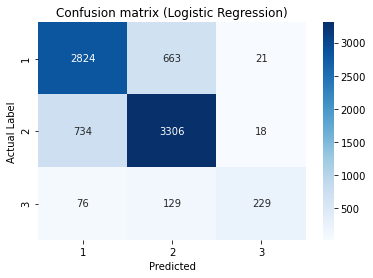

In [49]:
print(classification_report(y_dev, validation_set_prediction))
conf_matrix = confusion_matrix(y_dev, validation_set_prediction)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.title('Confusion matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual Label')
plt.show()

In [48]:
best_lr.predict(x_test_mi)

array([2., 1., 1., ..., 1., 1., 2.])

## Support Vector Machine

In [27]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1.668, max_iter=10000)
svm.fit(x_train_mi, y_train)
print("Training Accuracy:", svm.score(x_train_mi, y_train))
print("Holdout Accuracy:", svm.score(x_dev_mi, y_dev))
validation_set_prediction = svm.predict(x_dev_mi)

Training Accuracy: 0.81171875
Holdout Accuracy: 0.79325


In [28]:
pipeline = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1, 2))),
    ('Feature Selection', SelectKBest(score_func=mutual_info_classif, k=1000)),
    ('SVM', LinearSVC(C=1.668, max_iter=10000))
])

scores = cross_val_score(pipeline, X_train, y_train, cv=folds)
print("Stratified 5-fold Cross Validation Averaged Accuracy:", scores.mean())
print(scores)

Stratified 5-fold Cross Validation Averaged Accuracy: 0.79003125
[0.78484375 0.791875   0.78453125 0.79078125 0.798125  ]


              precision    recall  f1-score   support

         1.0       0.77      0.81      0.79      3508
         2.0       0.81      0.81      0.81      4058
         3.0       0.89      0.52      0.66       434

    accuracy                           0.79      8000
   macro avg       0.82      0.71      0.75      8000
weighted avg       0.80      0.79      0.79      8000



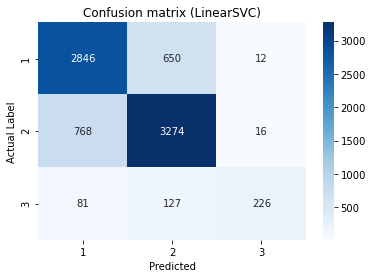

In [29]:
print(classification_report(y_dev, validation_set_prediction))
conf_matrix = confusion_matrix(y_dev, validation_set_prediction)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.title('Confusion matrix (LinearSVC)')
plt.xlabel('Predicted')
plt.ylabel('Actual Label')
plt.show()

In [51]:
svm.predict(x_test_mi)

array([2., 1., 1., ..., 1., 1., 2.])

## Validation Curve for LinearSVC

In [30]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-2, 2, 10)
train_score, validation_scores = validation_curve(
    LinearSVC(max_iter=10000), x_train_mi, y_train, 
    param_name='C', param_range=param_range, n_jobs=-1, verbose=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  50 | elapsed:    4.5s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.9min finished


In [31]:
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
mean_valid_score = np.mean(validation_scores, axis=1)
std_valid_score = np.std(validation_scores, axis=1)

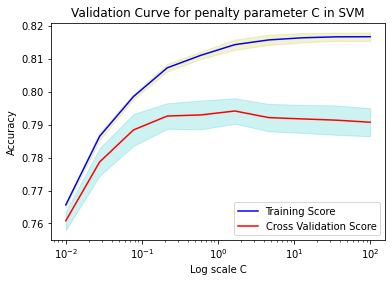

In [32]:
plt.semilogx(param_range, mean_train_score, label='Training Score', color='b')
plt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='y')
plt.semilogx(param_range, mean_valid_score, label='Cross Validation Score', color='r')
plt.fill_between(param_range, mean_valid_score - std_valid_score, mean_valid_score + std_valid_score, alpha=0.2, color='c')
plt.legend(loc='best')
plt.title('Validation Curve for penalty parameter C in SVM')
plt.xlabel('Log scale C')
plt.ylabel('Accuracy')
plt.show()

In [33]:
best_c_value = param_range[mean_valid_score.argmax()]
best_c_value

1.6681005372000592

## Learning Curve with different training size

In [25]:
from sklearn.model_selection import learning_curve

train_size, train_score, validation_score = learning_curve(
    LinearSVC(C=best_c_value, max_iter=10000), x_train_mi, y_train,
    train_sizes=np.linspace(0.1, 1, 5), cv=5, n_jobs=-1, verbose=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:    3.5s remaining:   40.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.4s finished


In [26]:
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
mean_valid_score = np.mean(validation_score, axis=1)
std_valid_score = np.std(validation_score, axis=1)

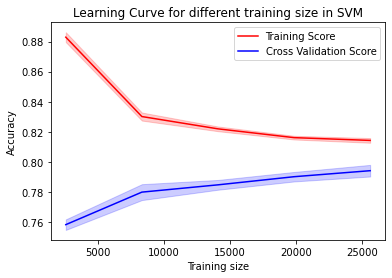

In [27]:
plt.plot(train_size, mean_train_score, label='Training Score', color='r')
plt.fill_between(train_size, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='r')
plt.plot(train_size, mean_valid_score, label='Cross Validation Score', color='b')
plt.fill_between(train_size, mean_valid_score - std_valid_score, mean_valid_score + std_valid_score, alpha=0.2, color='b')

plt.legend(loc='best')
plt.title('Learning Curve for different training size in SVM')
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

## Stacking

In [55]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

estimators = [
    ('MNB', MultinomialNB()),
    ('Logistic', LogisticRegression(C=2, max_iter=1000)),
    ('SVC', LinearSVC(C=1.668, max_iter=10000)),
    ('RF', RandomForestClassifier(max_depth=10, n_estimators=500)), 
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=1000)
)

clf.fit(x_train_mi, y_train)
print('Stacking Training Accuracy:', clf.score(x_train_mi, y_train))
print('Stacking Validation Accuracy:', clf.score(x_dev_mi, y_dev))
validation_prediction = clf.predict(x_dev_mi)

Stacking Training Accuracy: 0.82421875
Stacking Validation Accuracy: 0.8025


In [38]:
pipeline = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1, 2))),
    ('Feature Selection', SelectKBest(score_func=mutual_info_classif, k=1000)),
    ('clf', clf)
])

scores = cross_val_score(pipeline, X_train, y_train, cv=folds)
print("Stratified 5-fold Cross Validation Averaged Accuracy:", scores.mean())
print(scores)

Stratified 5-fold Cross Validation Averaged Accuracy: 0.799125
[0.79265625 0.79921875 0.798125   0.79859375 0.80703125]


              precision    recall  f1-score   support

         1.0       0.78      0.82      0.80      3508
         2.0       0.82      0.82      0.82      4058
         3.0       0.88      0.54      0.67       434

    accuracy                           0.80      8000
   macro avg       0.83      0.73      0.76      8000
weighted avg       0.80      0.80      0.80      8000



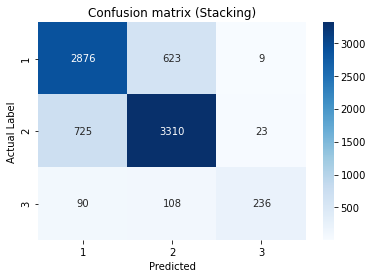

In [39]:
print(classification_report(y_dev, validation_prediction))
conf_matrix = confusion_matrix(y_dev, validation_prediction)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.title('Confusion matrix (Stacking)')
plt.xlabel('Predicted')
plt.ylabel('Actual Label')
plt.show()